In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
hatch_patterns = [x*2 for x in ('x', '-','\\', '+',  '*', 'o', 'O', '.')]
edgecolor='black'
sns.set_palette('Paired')



In [115]:
data_100k=pd.read_parquet('all.parquet', engine='pyarrow')
data_100k=data_100k[data_100k['operator']!='Noop']
data_100k=data_100k[(data_100k['num_cores']<100)&(data_100k['num_cores']!=24)]
models=['Linear Regression','Logistic Regression','Gaussian','KMeans']
# scalars=['Left multiply','Right multiply','Row summation','Column summation','Left multiply T','Right multiply T','Row summation T','Column summation T']
scalars=['Left multiply','Row summation','Column summation','Left multiply T']
matrix=['LMM','RMM','LMM T','RMM T']
selected_ops=['Left multiply','Column summation','LMM','RMM T']
selected_ops_latex=[r'$T \oslash x$',r'colSums($T$)',r'$TX$','$XT^T$']
# scalars_latex=[r'$T \oslash x$',r'$x \oslash T$',r'rowSums($T$)', r'colSums($T$)',r'$T^T \oslash x$',r'$x \oslash T^T$',r'rowSums($T^T$)', r'colSums($T^T$)']
scalars_latex=[r'$T \oslash x$',r'rowSums($T$)', r'colSums($T$)',r'$T^T \oslash x$']
matrix_latex=[r'$TX$',r'$XT$',r'$T^TX$',r'$XT^T$']
ma=data_100k[data_100k['method']=='materialized'].reset_index(drop=True)
fa=data_100k[data_100k['method']=='factorized'].reset_index(drop=True)
ma['spdup']=ma['time']/fa['time']
ma=ma[ma['spdup']>0]
ma['CR_interval'] = pd.cut(ma['CR'], bins=5)


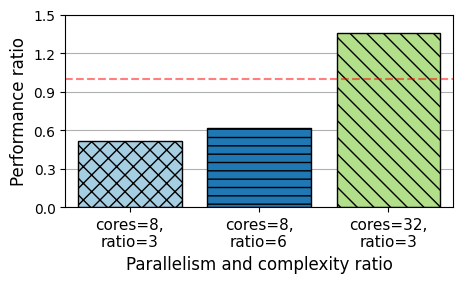

In [141]:

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,2.5))
sample=pd.DataFrame([['cores=8,\nratio=3','cores=8,\nratio=6','cores=32,\nratio=3'],[0.519,0.62,1.36]]).T
sample.columns=['labels','spdup']
g=sns.barplot(ax=axes,x='labels',y='spdup',data=sample,edgecolor=edgecolor)
g.axhline(1,c='r',alpha=0.5,linestyle='--')
axes.set_ylabel('Performance ratio', fontsize=12)
axes.set_xlabel('Parallelism and complexity ratio', fontsize=12)
ma[(ma['operator'].isin(['Linear Regression']) )& (ma['num_cores']==32)& (ma['size']==1000000) & (ma['CR']==3)]['spdup'].max()
axes.grid(axis='y')


for bar, pattern, color in zip(axes.containers[0], hatch_patterns, sns.color_palette('Paired')):
    plt.setp(bar, hatch=pattern)
    plt.setp(bar, facecolor=color)

axes.set_axisbelow(True)
axes.set_yticks([0,0.3,0.6,0.9,1.2,1.5])

for label in axes.xaxis.get_ticklabels():
    label.set_fontsize(11)
        
# fig.tight_layout()

fig.savefig("figures/preliminaries.pdf",bbox_inches='tight')


In [136]:
axes.containers[0][2]

/tmp/ipykernel_5503/3516243115.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g=sns.barplot(ax=axes[i][j],x='operator', y='spdup', hue=h[i][j], data=ma[ma['operator'].isin(selected_ops)], ci=None)
/tmp/ipykernel_5503/3516243115.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g=sns.barplot(ax=axes[i][j],x='operator', y='spdup', hue=h[i][j], data=ma[ma['operator'].isin(selected_ops)], ci=None)
/tmp/ipykernel_5503/3516243115.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g=sns.barplot(ax=axes[i][j],x='operator', y='spdup', hue=h[i][j], data=ma[ma['operator'].isin(selected_ops)], ci=None)
/tmp/ipykernel_5503/3516243115.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=15)
/tmp/ipyke

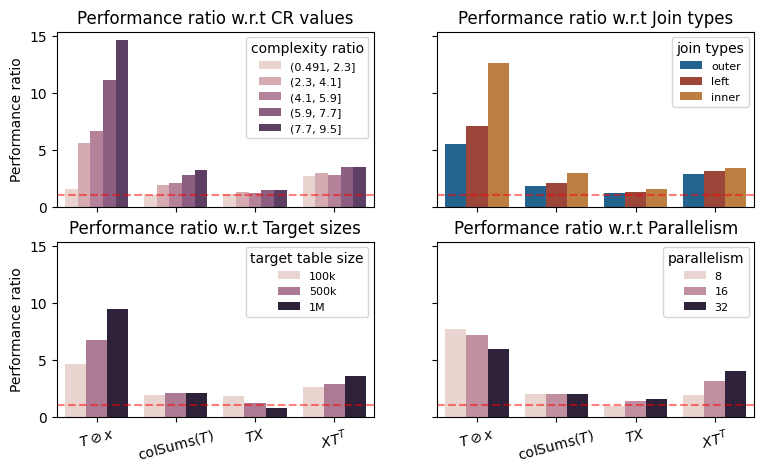

In [143]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9,5))
h=[['CR_interval','join'],['size','num_cores']]
colors=[[sns.cubehelix_palette(),['#13679E','#AB3A29','#D07F2C']],[sns.light_palette(color='#CF3D3F',n_colors=5,reverse=False,input='RGB')[2:],sns.light_palette(color='#6972A2',n_colors=6,reverse=False,input='RGB')[3:]]]
for i in range(2):
    for j in range(2):
        sns.set_palette(colors[i][j])
        g=sns.barplot(ax=axes[i][j],x='operator', y='spdup', hue=h[i][j], data=ma[ma['operator'].isin(selected_ops)], ci=None)
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=15)
        axes[i][j].set_xlabel('')
        if i==0 and j==0:
            axes[i][j].set_title(f'Performance ratio w.r.t CR values')
            axes[i][j].legend(title='complexity ratio',fontsize=8)
            axes[i][j].set_ylabel(r'Performance ratio')
        elif i==0 and j==1:
            axes[i][j].set_title(f'Performance ratio w.r.t Join types')   
            axes[i][j].legend(title='join types',fontsize=8)
            axes[i][j].set_ylabel('')
        elif i==1 and j==0:
            axes[i][j].set_title(f'Performance ratio w.r.t Target sizes')
            axes[i][j].legend(title='target table size',fontsize=8,labels=['100k','500k','1M'])
            axes[i][j].set_xticklabels(selected_ops_latex)
            axes[i][j].set_ylabel(r'Performance ratio')

        else:
            axes[i][j].set_title(f'Performance ratio w.r.t Parallelism')
            axes[i][j].legend(title='parallelism',fontsize=8)
            axes[i][j].set_xticklabels(selected_ops_latex)
            axes[i][j].set_ylabel('')
        g.axhline(1,c='r',alpha=0.5,linestyle='--')

fig.savefig("figures/scalar_core_cr.pdf",bbox_inches='tight')

/tmp/ipykernel_5503/110783019.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g=sns.barplot(ax=axes[i][j],x='operator', y='spdup', hue=h[i][j], data=ma[ma['operator'].isin(matrix)], ci=None)
/tmp/ipykernel_5503/110783019.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i][j].set_xticklabels(matrix_latex)
/tmp/ipykernel_5503/110783019.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g=sns.barplot(ax=axes[i][j],x='operator', y='spdup', hue=h[i][j], data=ma[ma['operator'].isin(matrix)], ci=None)
/tmp/ipykernel_5503/110783019.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i][j].set_xticklabels(matrix_latex)
/tmp/ipykernel_5503/110783019.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `erro

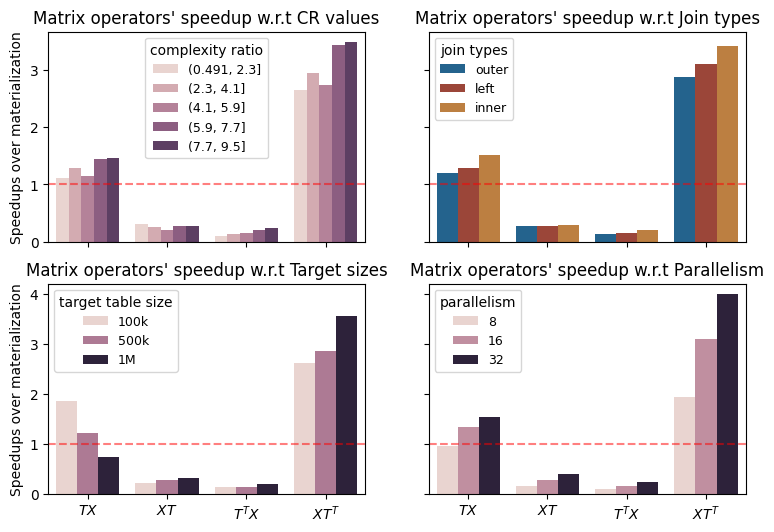

In [144]:
#3.matrix op spdup vs complexity ratio and parallleism
fig, axes = plt.subplots(2, 2, sharex=True, sharey='True', figsize=(9,6))
h=[['CR_interval','join'],['size','num_cores']]
colors=[[sns.cubehelix_palette(),['#13679E','#AB3A29','#D07F2C']],[sns.light_palette(color='#CF3D3F',n_colors=5,reverse=False,input='RGB')[2:],sns.light_palette(color='#6972A2',n_colors=6,reverse=False,input='RGB')[3:]]]
for i in range(2):
    for j in range(2):
        sns.set_palette(colors[i][j])
        g=sns.barplot(ax=axes[i][j],x='operator', y='spdup', hue=h[i][j], data=ma[ma['operator'].isin(matrix)], ci=None)

        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels())
        axes[i][j].set_xlabel('')
        if i==0 and j==0:
            axes[i][j].set_title(f'Matrix operators\' speedup w.r.t CR values')
            axes[i][j].set_xticklabels(matrix_latex)
            axes[i][j].set_ylabel(r'Speedups over materialization')
            axes[i][j].legend(title='complexity ratio',fontsize=9)
        elif i==0 and j==1:
            axes[i][j].set_title(f'Matrix operators\' speedup w.r.t Join types')
            axes[i][j].set_xticklabels(matrix_latex)
            axes[i][j].set_ylabel('')
            axes[i][j].legend(title='join types',fontsize=9)
        elif i==1 and j==0:
            axes[i][j].set_title(f'Matrix operators\' speedup w.r.t Target sizes')
            axes[i][j].set_xticklabels(matrix_latex)
            axes[i][j].set_ylabel(r'Speedups over materialization')
            axes[i][j].legend(title='target table size',fontsize=9,labels=['100k','500k','1M'])

        else:
            axes[i][j].set_title(f'Matrix operators\' speedup w.r.t Parallelism')
            axes[i][j].set_xticklabels(matrix_latex)
            axes[i][j].set_ylabel('')
            axes[i][j].legend(title='parallelism',fontsize=9)
        g.axhline(1,c='r',alpha=0.5,linestyle='--')

fig.savefig("figures/matrix_all.pdf",bbox_inches='tight')


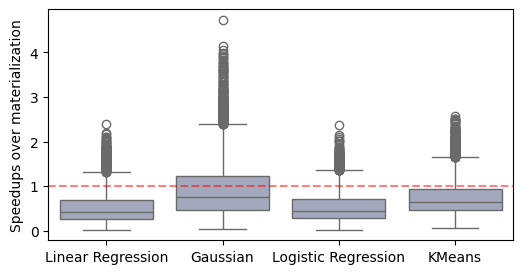

In [95]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6,3))
sns.set_palette(sns.light_palette(color='#CF3D3F',n_colors=5,reverse=False,input='RGB')[2:])
ma_copy=ma.copy()
ma_copy['inv_spdup']=1/ma_copy['spdup']
g1=sns.boxplot(ax=axes,x='operator', y='spdup', data=ma_copy[(ma_copy['operator'].isin(models))])#,estimator=np.median,ci=None)

axes.set_xlabel('')
    
axes.set_ylabel(r'Speedups over materialization')

g1.axhline(1,c='r',alpha=0.5,linestyle='--')


fig.savefig("figures/models_size_join.pdf",bbox_inches='tight')

/tmp/ipykernel_5503/3825966739.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g1=sns.barplot(ax=axes[i],x='operator', y='spdup', hue=h[i], data=ma[ma['operator'].isin(models)], ci=None)
/tmp/ipykernel_5503/3825966739.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g1=sns.barplot(ax=axes[i],x='operator', y='spdup', hue=h[i], data=ma[ma['operator'].isin(models)], ci=None)
/tmp/ipykernel_5503/3825966739.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels())


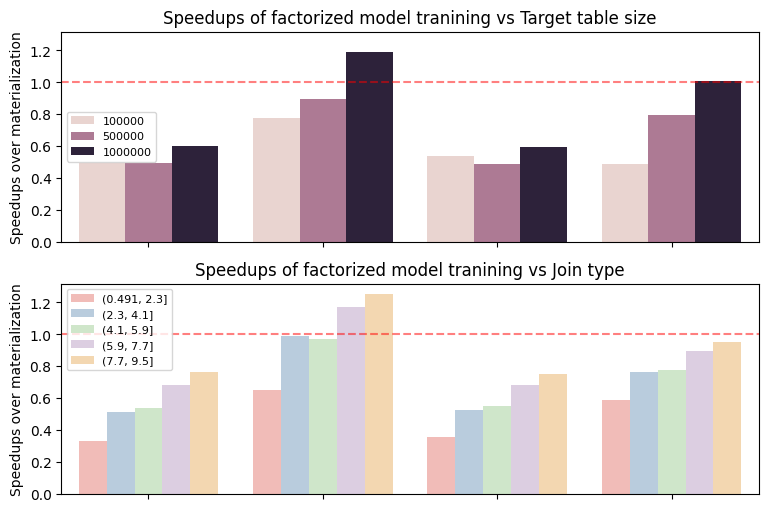

In [96]:

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(9,6))
h=['size','CR_interval']
colors=['Dark2','Pastel1']
j=0
for i in range(2):
    sns.set_palette(colors[i])
    g1=sns.barplot(ax=axes[i],x='operator', y='spdup', hue=h[i], data=ma[ma['operator'].isin(models)], ci=None)
    # axes[i][j].set_title('Speedup of Different Operators for Different CR Intervals')
    axes[i].set_xticklabels(axes[i].get_xticklabels())
    axes[i].legend(title=h[i])
    axes[i].set_xlabel('')
    axes[i].legend(fontsize=8)
    if i==0:
        axes[i].set_title(f'Speedups of factorized model tranining vs Target table size')
    else:
        axes[i].set_title(f'Speedups of factorized model tranining vs Join type')
    axes[i].set_ylabel('Speedups over materialization')
    g1.axhline(1,c='r',alpha=0.5,linestyle='--')


fig.savefig("figures/models_size_join.pdf",bbox_inches='tight')

/tmp/ipykernel_5503/4208608278.py:3: FutureWarning: The provided callable <function median at 0x7fa7c411af80> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  pivot_table = data_subset.pivot_table(values='spdup', index='num_cores', columns='CR', aggfunc=np.median)


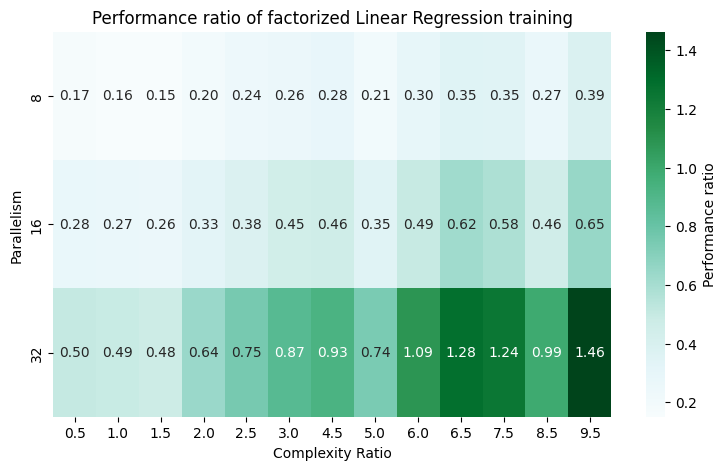

In [97]:

data_subset=ma[ma['operator']=='Linear Regression']

pivot_table = data_subset.pivot_table(values='spdup', index='num_cores', columns='CR', aggfunc=np.median)

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(9,5))
sns.heatmap(pivot_table, annot=True, cmap='BuGn', fmt='.2f',ax=axes,cbar_kws={'label': 'Performance ratio'})
axes.set_xlabel('Complexity Ratio')
axes.set_ylabel('Parallelism')
plt.title('Performance ratio of factorized Linear Regression training')
fig.savefig("figures/models_cr_core_heat.pdf",bbox_inches='tight')

# Tree-boosting estimator

In [98]:
def preprocessing_features(raw_features,parallelism,selectivity):
    output=np.zeros(41)
    total_mem_ma=np.sum(raw_features[[0,1,14,15,16,17,19,20,22,23]])
    total_mem_fa=np.sum(raw_features[[2,3,14,15,16,17,19,20,22,23]])
    output[0:2]=raw_features[0:2]/total_mem_ma  #materialized memory read, write
    output[2:4]=raw_features[2:4]/total_mem_fa  #factorized memory read, write
    output[4:7]=raw_features[4:7]/raw_features[24]/parallelism #scalar, LMM, RMM complexity with materialization
    output[7:10]=raw_features[7:10]/raw_features[25]/parallelism #scalar, LMM, RMM complexity with factorization
    output[10]=raw_features[10]/raw_features[24]/parallelism # col-major ops complexity with materialization
    output[11]=raw_features[11]/raw_features[25]/parallelism # col-major ops complexity with factorization
    output[12]=raw_features[12]/parallelism/raw_features[24] # dense scalar op complexity/total materialization complxity
    output[13]=raw_features[12]/parallelism/raw_features[25] # dense scalar op complexity/total factorization complxity
    output[14]=raw_features[13]/parallelism/raw_features[24] # dense MM op complexity/total materialization complxity
    output[15]=raw_features[13]/parallelism/raw_features[25] # dense MM op complexity/total factorization complxity
    output[16:20]=raw_features[14:18]/total_mem_ma #dense scalar read and write, dense MM read and write / total materialization memory
    output[20:24]=raw_features[14:18]/total_mem_fa #dense scalar read and write, dense MM read and write / total factorization memory
    output[24:28]=raw_features[[19,20,22,23]]/total_mem_ma #colSum read and write, rowSum read and write / total materialization memory
    output[28:32]=raw_features[[19,20,22,23]]/total_mem_fa #colSum read and write, rowSum read and write / total factorization memory
    output[32:34]=raw_features[[18,21]]/parallelism/raw_features[24] #colSum  and rowSum complexity / total materialization complexity
    output[34:36]=raw_features[[18,21]]/parallelism/raw_features[25] #colSum  and rowSum complexity / total factorization complexity
    output[38]=raw_features[24]/raw_features[25] # complexity ratio
    output[39:41]=raw_features[26:28] #Tuple ratio, feature ratio
    output[36]=selectivity #selectivity
    return output

def preprocessing_features_no_hw(raw_features,parallelism,selectivity):
    output=np.zeros(41)
    total_mem_ma=np.sum(raw_features[[0,1,14,15,16,17,19,20,22,23]])
    total_mem_fa=np.sum(raw_features[[2,3,14,15,16,17,19,20,22,23]])
    output[0:2]=raw_features[0:2]/total_mem_ma
    output[2:4]=raw_features[2:4]/total_mem_fa 
    output[4:7]=raw_features[4:7]/raw_features[24]
    output[7:10]=raw_features[7:10]/raw_features[25]
    output[10]=raw_features[10]/raw_features[24]
    output[11]=raw_features[11]/raw_features[25]
    output[12]=raw_features[12]/raw_features[24]
    output[13]=raw_features[12]/raw_features[25]
    output[14]=raw_features[13]/raw_features[24]
    output[15]=raw_features[13]/raw_features[25]
    output[16:20]=raw_features[14:18]/total_mem_ma
    output[20:24]=raw_features[14:18]/total_mem_fa
    output[24:28]=raw_features[[19,20,22,23]]/total_mem_ma
    output[28:32]=raw_features[[19,20,22,23]]/total_mem_fa
    output[32:34]=raw_features[[18,21]]/raw_features[24]
    output[34:36]=raw_features[[18,21]]/raw_features[25]
    output[38]=raw_features[24]/raw_features[25]
    output[39:41]=raw_features[26:28]
    output[36]=selectivity
    return output

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import xgboost as xgb

# xgb_features=pd.read_parquet('xgb_features_no_hw.parquet', engine='pyarrow')
xgb_features=pd.read_parquet('xgb_features_norm.parquet', engine='pyarrow')
splitted=train_test_split(xgb_features,test_size=0.2,random_state=42)
# leave_out='Logistic Regression'
# splitted[0]=splitted[0][splitted[0]['operator']!=leave_out]
# splitted[1]=splitted[1][splitted[1]['operator']==leave_out]
train_feature=np.array(splitted[0]['features'].to_list())
train_label=np.array(splitted[0]['labels'].to_list())
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=train_label

)


In [100]:

from sklearn.model_selection import GridSearchCV
cv_params={'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}#{'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}#{'max_depth':[3,4,5,6,7,8,9,10],'min_child_weight':[1,2,3,4,5,6,7,8,9,10],'gamma':[0,0.1,0.2,0.3,0.4,0.5]} #{'n_estimators':[50,100,200,400,500],'learning_rate':[0.01,0.05,0.1,0.2,0.3]}#
other_params={'learning_rate':0.2,'n_estimators':400,'max_depth':8,'min_child_weight':1,'seed':0,'subsample':0.7,'colsample_bytree':0.8,'gamma':0.2,'reg_alpha':1,'reg_lambda':0.1}
model=xgb.XGBClassifier()
optimized=GridSearchCV(estimator=model,param_grid=cv_params,scoring='roc_auc',cv=3,verbose=2,n_jobs=8)
optimized.fit(train_feature,train_label,sample_weight=classes_weights)
evalute_result=optimized.cv_results_
evalute_result.get('params')[np.argmax(evalute_result.get('mean_test_score'))]

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END ....................reg_alpha=0.05, reg_lambda=0.05; total time=   1.1s
[CV] END .....................reg_alpha=0.05, reg_lambda=0.1; total time=   1.1s
[CV] END .......................reg_alpha=0.05, reg_lambda=1; total time=   1.1s
[CV] END .......................reg_alpha=0.05, reg_lambda=1; total time=   1.1s
[CV] END ....................reg_alpha=0.05, reg_lambda=0.05; total time=   1.2s
[CV] END ....................reg_alpha=0.05, reg_lambda=0.05; total time=   1.3s
[CV] END .....................reg_alpha=0.05, reg_lambda=0.1; total time=   1.3s
[CV] END .....................reg_alpha=0.05, reg_lambda=0.1; total time=   1.3s
[CV] END .......................reg_alpha=0.05, reg_lambda=1; total time=   1.1s
[CV] END .......................reg_alpha=0.05, reg_lambda=2; total time=   1.2s
[CV] END .......................reg_alpha=0.05, reg_lambda=3; total time=   1.1s
[CV] END .......................reg_alpha=0.05, 

{'reg_alpha': 1, 'reg_lambda': 0.05}

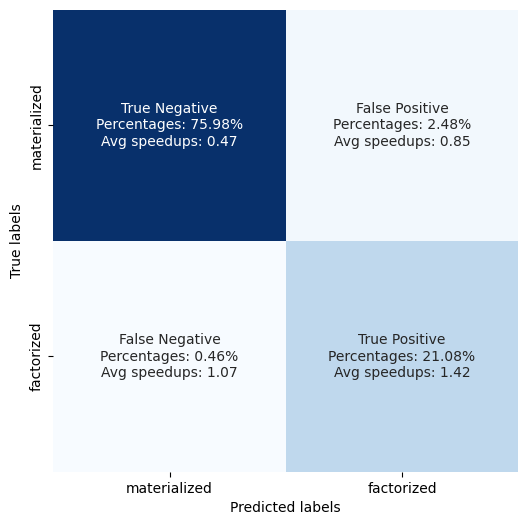

accuracy: 0.9705635868426566
f1 score: 0.9347270615563298
avg speedup of True Positive: 1.4161190462622304
avg speedup of False Positive: 0.8447818695499778
avg speedup of True Negative: 0.4736812793396823
avg speedup of False Negative: 1.0575064491422235


In [101]:
import matplotlib.pyplot as plt

best_params={'learning_rate':0.2,'n_estimators':400,'max_depth':8,'min_child_weight':1,'seed':0,'subsample':0.7,'colsample_bytree':0.8,'gamma':0.2,'reg_alpha':1,'reg_lambda':0.1}
test=np.array(splitted[1]['features'].to_list())
b=np.array(splitted[1]['labels'].to_list())
spd=splitted[1]['spd']
best=xgb.XGBClassifier(**best_params)
best.fit(train_feature,train_label,sample_weight=classes_weights)
# best.fit(balanced_train,balanced_label)

pred_probs=best.predict_proba(test)
xgb_result=(pred_probs[:,1]>0.5)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score
cf=confusion_matrix(b, xgb_result)
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
# disp = ConfusionMatrixDisplay(confusion_matrix=cf,
#                               display_labels=['materialized','factorized'])
# disp.plot(cmap=sns.color_palette("rocket", as_cmap=True)
# ,ax=axes,colorbar=False)#
# axes.set_yticklabels(['materialized','factorized'],rotation=90)

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['Counts: {0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['Percentages: {0:.2%}'.format(value) for value in
                     cf.flatten()/np.sum(cf)]
group_spdup=['Avg speedups: {0:.2f}'.format(value) for value in [0.47414733263902503,0.8462182606908432,1.0682843848938115,1.4169230237274053]]
labels = [f'{v1}\n{v3}\n{v4}' for v1, v2, v3, v4 in
          zip(group_names,group_counts,group_percentages,group_spdup)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues',ax=axes,cbar=False)
axes.set_yticklabels(['materialized','factorized'],rotation=90)
axes.set_xticklabels(['materialized','factorized'])
axes.set_xlabel('Predicted labels')
axes.set_ylabel('True labels')

fig.savefig("figures/xgb_confusion.pdf",bbox_inches='tight')

plt.show()

print('accuracy:',accuracy_score(b,xgb_result))
print('f1 score:',f1_score(b,xgb_result))
print('avg speedup of True Positive:',np.mean(spd[(b==True) & (xgb_result==True)]))
print('avg speedup of False Positive:',np.mean(spd[(b==False) & (xgb_result==True)]))
print('avg speedup of True Negative:',np.mean(spd[(b==False) & (xgb_result==False)]))
print('avg speedup of False Negative:',np.mean(spd[(b==True) & (xgb_result==False)]))

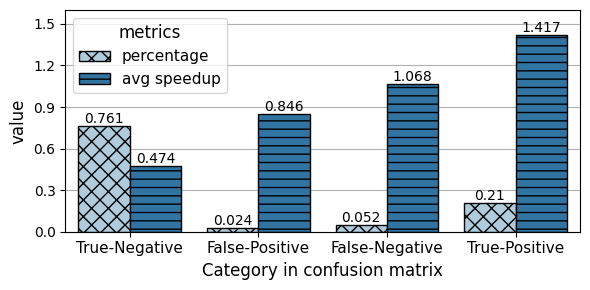

In [102]:


insight_1=[['True-Negative','False-Positive','False-Negative','True-Positive','True-Negative','False-Positive','False-Negative','True-Positive'],[0.761,0.024,0.052,0.210, 0.474,0.846,1.068,1.417],['percentage','percentage','percentage','percentage','avg speedup','avg speedup','avg speedup','avg speedup']]
insight_1=pd.DataFrame(insight_1).T
insight_1.columns=['model','value','metrics']
sns.set_palette('Paired')
fig,ax=plt.subplots(1,1,figsize=(6,3))
sns.barplot(ax=ax,x='model',y='value',hue='metrics',data=insight_1, edgecolor=edgecolor)
ax.set_xlabel('Category in confusion matrix')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_ylim(0,1.6)

legends=[]
for bar, pattern, label in zip(ax.containers, hatch_patterns, ['percentage', 'avg speedup']):
    plt.setp(bar, hatch=pattern)
    barinfo = bar.patches[0]
    legends.append(mpatches.Patch(facecolor=barinfo.get_facecolor(), label=label, edgecolor=barinfo.get_edgecolor(), hatch=barinfo.get_hatch()))

ax.set_ylabel(ax.get_ylabel(), fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_yticks([0,0.3,0.6,0.9,1.2,1.5])
ax.set_ylim([0,1.6])

for label in ax.xaxis.get_ticklabels():
    label.set_fontsize(11)

ax.legend(handles=legends, fontsize=11, title='metrics', title_fontsize=12)
        
fig.tight_layout()

fig.savefig("figures/new_cf.pdf",bbox_inches='tight')

In [103]:

splitted[1]['pred']=xgb_result
# splitted[1]['expct_spd']=splitted[1]['spd']*b
large_scale=splitted[1][splitted[1]['num_cores']==32]
print((large_scale['spd']*large_scale['pred']).apply(lambda x:1 if x==0 else x).mean())
print((large_scale['spd']*large_scale['labels']).apply(lambda x:1 if x==0 else x).mean())


1.2396995506363084
1.243794146936547


In [104]:
#TR
large_scale=splitted[1]
feas=np.array(large_scale['features'].to_list())
b=np.array(large_scale['labels'].to_list())
tr_result=(feas[:,39]>5) & (feas[:,40]>1)
print('TR accuracy:',accuracy_score(b,tr_result))
print('TR f1 score:',f1_score(b,tr_result))
cr_result=feas[:,38]>1
print('CR accuracy:',accuracy_score(b,cr_result))
print('CR f1 score:',f1_score(b,cr_result))
sel_result=feas[:,36]>1
print('Sel accuracy:',accuracy_score(b,sel_result))
print('Sel f1 score:',f1_score(b,sel_result))
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(class_weight='balanced',max_iter=1000)
lr.fit(train_feature,train_label)
pred_probs=lr.predict_proba(feas)
lr_result=(pred_probs[:,1]>0.5)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf=confusion_matrix(b, lr_result)
print('LR accuracy:',accuracy_score(b,lr_result))
print('LR f1 score:',f1_score(b,lr_result))


TR accuracy: 0.490467211397444
TR f1 score: 0.42587346553352223
CR accuracy: 0.4468887492143306
CR f1 score: 0.4207985958753839
Sel accuracy: 0.24376702283679028
Sel f1 score: 0.3623354827312075
LR accuracy: 0.7758223339618688
LR f1 score: 0.618945868945869


In [105]:
large_scale=splitted[1][splitted[1]['num_cores']==32]
feas=np.array(large_scale['features'].to_list())
b=np.array(large_scale['labels'].to_list())
tr_result=(feas[:,39]>5) & (feas[:,40]>1)
print('TR spdup:',(large_scale['spd']*tr_result).apply(lambda x:1 if x==0 else x).mean())
cr_result=feas[:,38]>1
print('CR spdup:',(large_scale['spd']*cr_result).apply(lambda x:1 if x==0 else x).mean())
sel_result=feas[:,36]>1
print('Sel spdup:',(large_scale['spd']*sel_result).apply(lambda x:1 if x==0 else x).mean())
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(class_weight='balanced',max_iter=1000)
lr.fit(train_feature,train_label)
pred_probs=lr.predict_proba(feas)
lr_result=(pred_probs[:,1]>0.5)
from sklearn.metrics import confusion_matrix
cf=confusion_matrix(b, lr_result)
print('LR spdup:',(large_scale['spd']*lr_result).apply(lambda x:1 if x==0 else x).mean())

TR spdup: 1.1620313177625456
CR spdup: 1.1646888907840898
Sel spdup: 1.0891138753773846
LR spdup: 1.203488696185764


In [106]:
scores=best.get_booster().get_score(importance_type='gain')
scores=[[int(k[1:]),v] for k,v in sorted(scores.items(),key=lambda item:item[1],reverse=True)]
scores

[[8, 29.756650924682617],
 [12, 23.879987716674805],
 [25, 19.40923309326172],
 [10, 14.384042739868164],
 [5, 14.287442207336426],
 [14, 7.789100646972656],
 [1, 7.465024948120117],
 [38, 6.9178547859191895],
 [18, 5.152710914611816],
 [40, 4.146862983703613],
 [24, 3.8964788913726807],
 [11, 3.5436384677886963],
 [20, 3.419510841369629],
 [0, 3.168954372406006],
 [34, 2.9894356727600098],
 [15, 2.988678455352783],
 [30, 2.8361008167266846],
 [22, 2.6256566047668457],
 [2, 2.583073139190674],
 [27, 2.3442535400390625],
 [33, 2.3219666481018066],
 [16, 2.140465021133423],
 [7, 2.0352587699890137],
 [23, 1.9562292098999023],
 [32, 1.9197896718978882],
 [13, 1.9161922931671143],
 [28, 1.844618558883667],
 [39, 1.8083165884017944],
 [3, 1.7956002950668335],
 [21, 1.6264373064041138],
 [36, 1.5289918184280396],
 [4, 1.5173875093460083],
 [19, 1.3586184978485107],
 [26, 1.3214823007583618],
 [29, 1.087347149848938],
 [35, 1.0502653121948242],
 [17, 0.82463139295578]]

/tmp/ipykernel_5503/2742120774.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()], rotation=0)


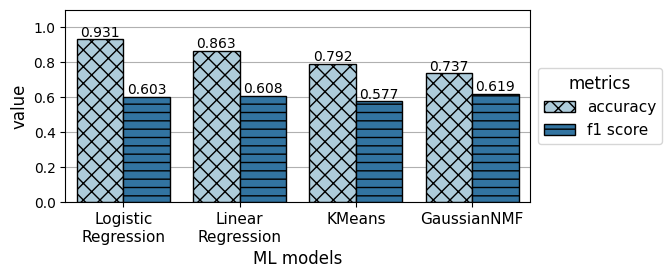

In [107]:
# predicted=splitted[1]
# predicted['pred']=xgb_result
# model_acc=[]
# for i in models:
#     temp_label=predicted[predicted['operator']==i]['labels']
#     temp_pred=predicted[predicted['operator']==i]['pred']
#     model_acc.append([i,accuracy_score(temp_label,temp_pred),'accuracy'])
#     model_acc.append([i,f1_score(temp_label,temp_pred),'f1 score'])
# join_acc=[]
# for i in ['outer','inner','left']:
#     temp_label=predicted[predicted['join']==i]['labels']
#     temp_pred=predicted[predicted['join']==i]['pred']
#     join_acc.append([i,accuracy_score(temp_label,temp_pred),'accuracy'])
#     join_acc.append([i,f1_score(temp_label,temp_pred),'f1 score'])
# model_acc=pd.DataFrame(model_acc,columns=['model','value','metrics'])
# join_acc=pd.DataFrame(join_acc,columns=['model','value','metrics'])

insight_1=[['Logistic Regression','Linear Regression','KMeans','GaussianNMF','Logistic Regression','Linear Regression','KMeans','GaussianNMF'],[0.931,0.863,0.792,0.737, 0.603,0.608,0.577,0.619],['accuracy','accuracy','accuracy','accuracy','f1 score','f1 score','f1 score','f1 score']]
insight_1=pd.DataFrame(insight_1).T
insight_1.columns=['model','value','metrics']
sns.set_palette('Paired')
fig,ax=plt.subplots(1,1,figsize=(6,2.5))
sns.barplot(ax=ax,x='model',y='value',hue='metrics',data=insight_1, edgecolor=edgecolor)
ax.set_xlabel('ML models', fontsize=12)
ax.set_ylim(0,1.1)

for i in ax.containers:
    ax.bar_label(i,)

legends=[]
for bar, pattern, label in zip(ax.containers, hatch_patterns, ['accuracy', 'f1 score']):
    plt.setp(bar, hatch=pattern)
    barinfo = bar.patches[0]
    legends.append(mpatches.Patch(facecolor=barinfo.get_facecolor(), label=label, edgecolor=barinfo.get_edgecolor(), hatch=barinfo.get_hatch()))

ax.set_ylabel(ax.get_ylabel(), fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_xticklabels([label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()], rotation=0)

for label in ax.xaxis.get_ticklabels():
    label.set_fontsize(11)

ax.legend(handles=legends, fontsize=11, title='metrics', title_fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout
fig.savefig("figures/xgb_model_category.pdf",bbox_inches='tight')

In [108]:
hamlet=pd.read_parquet('hamlet.parquet')
hamlet=hamlet[hamlet['operator'].isin(models)]
ma=hamlet[hamlet['model']=='materialized']
fa=hamlet[hamlet['model']=='factorized']
ma.reset_index(inplace=True)
fa.reset_index(inplace=True)
ma['spd']=ma['time']/fa['time']
ma['labels']=ma['spd']>1
feature_list=ma['features'].to_list()
parallelism=ma['num_cores'].to_list()
selectivity=ma['selectivity'].to_list()
for i in range(len(feature_list)):
    feature_list[i]=preprocessing_features(feature_list[i],int(parallelism[i]),selectivity[i]  )
ma['features']=feature_list

real_features=ma[['dataset','features','labels','num_cores','selectivity','join','operator','spd']]
# real_features.to_parquet('../sigmod_result/hamlet/hamlet_norm.parquet')

/tmp/ipykernel_5503/3668049856.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ma['spd']=ma['time']/fa['time']
/tmp/ipykernel_5503/3668049856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ma['labels']=ma['spd']>1
/tmp/ipykernel_5503/3668049856.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [109]:
test_hamlet=np.array(real_features['features'].to_list())
b_hamlet=np.array(real_features['labels'].to_list())
spd_hamlet=np.array(real_features['spd'].to_list())
pred_probs=best.predict_proba(test_hamlet)
xgb_result_hamlet=(pred_probs[:,1]>0.5)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score
cf=confusion_matrix(b_hamlet, xgb_result_hamlet)
# fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['Counts: {0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['Percentages: {0:.2%}'.format(value) for value in
                     cf.flatten()/np.sum(cf)]
group_spdup=['Avg speedups: {0:.2f}'.format(value) for value in [0.44539485647026914,0.74162260993942669,1.0771025806938251,1.486212465227844]]
labels = [f'{v1}\n{v3}\n{v4}' for v1, v2, v3, v4 in
          zip(group_names,group_counts,group_percentages,group_spdup)]
labels = np.asarray(labels).reshape(2,2)
# sns.heatmap(cf, annot=labels, fmt='', cmap='Blues',ax=axes,cbar=False)
# axes.set_yticklabels(['materialized','factorized'],rotation=90)
# axes.set_xticklabels(['materialized','factorized'])
# axes.set_xlabel('Predicted labels')
# axes.set_ylabel('True labels')
# fig.savefig("figures/xgb_confusion_real.pdf",bbox_inches='tight')

# plt.show()

print('accuracy:',accuracy_score(b_hamlet,xgb_result_hamlet))
print('f1 score:',f1_score(b_hamlet,xgb_result_hamlet))
print('avg speedup of True Positive:',np.mean(spd_hamlet[(b_hamlet==True) & (xgb_result_hamlet==True)]))
print('avg speedup of False Positive:',np.mean(spd_hamlet[(b_hamlet==False) & (xgb_result_hamlet==True)]))
print('avg speedup of True Negative:',np.mean(spd_hamlet[(b_hamlet==False) & (xgb_result_hamlet==False)]))
print('avg speedup of False Negative:',np.mean(spd_hamlet[(b_hamlet==True) & (xgb_result_hamlet==False)]))

accuracy: 0.8571428571428571
f1 score: 0.7391304347826085
avg speedup of True Positive: 1.4806131370887312
avg speedup of False Positive: 0.680252134718273
avg speedup of True Negative: 0.44654973864199354
avg speedup of False Negative: 1.1633146389374038


In [110]:
real_features['pred']=xgb_result_hamlet
# splitted[1]['expct_spd']=splitted[1]['spd']*b
large_scale_hamelet=real_features[real_features['num_cores']==32]
print((large_scale_hamelet['spd']*large_scale_hamelet['pred']).apply(lambda x:1 if x==0 else x).mean())
print((large_scale_hamelet['spd']*large_scale_hamelet['labels']).apply(lambda x:1 if x==0 else x).mean())

1.2282935560793535
1.2469259574053693


/tmp/ipykernel_5503/476372311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_features['pred']=xgb_result_hamlet


In [111]:

large_scale_hamelet=real_features.copy()
test_hamlet=np.array(large_scale_hamelet['features'].to_list())
b_hamlet=np.array(large_scale_hamelet['labels'].to_list())
tr_result=(test_hamlet[:,39]>5) & (test_hamlet[:,40]>1)

print('TR accuracy:',accuracy_score(b_hamlet,tr_result))
print('TR f1 score:',f1_score(b_hamlet,tr_result))
#complexity ration
cr_result=test_hamlet[:,38]>1
print('CR accuracy:',accuracy_score(b_hamlet,cr_result))
print('CR f1 score:',f1_score(b_hamlet,cr_result))
#selectivity
sel_result=test_hamlet[:,36]>1.01
print('Sel accuracy:',accuracy_score(b_hamlet,sel_result))
print('Sel f1 score:',f1_score(b_hamlet,sel_result))
#LR
from sklearn.linear_model import LogisticRegression
# lr=LogisticRegression(class_weight='balanced',max_iter=1000)
# lr.fit(train_feature,train_label)
pred_probs=lr.predict_proba(test_hamlet)
lr_result=(pred_probs[:,1]>0.5)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf=confusion_matrix(b_hamlet, lr_result)
print('LR accuracy:',accuracy_score(b_hamlet,lr_result))
print('LR f1 score:',f1_score(b_hamlet,lr_result))

TR accuracy: 0.4801587301587302
TR f1 score: 0.19631901840490795
CR accuracy: 0.38492063492063494
CR f1 score: 0.3404255319148936
Sel accuracy: 0.6150793650793651
Sel f1 score: 0.23622047244094488
LR accuracy: 0.6507936507936508
LR f1 score: 0.42105263157894735


In [112]:
large_scale_hamelet=real_features[real_features['num_cores']==32]
test_hamlet=np.array(large_scale_hamelet['features'].to_list())
b_hamlet=np.array(large_scale_hamelet['labels'].to_list())
tr_result=(test_hamlet[:,39]>5) & (test_hamlet[:,40]>1)
print('TR spdup:',(large_scale_hamelet['spd']*tr_result).apply(lambda x:1 if x==0 else x).mean())
cr_result=test_hamlet[:,38]>1
print('CR spdup:',(large_scale_hamelet['spd']*cr_result).apply(lambda x:1 if x==0 else x).mean())
sel_result=test_hamlet[:,36]>1.01
print('Sel spdup:',(large_scale_hamelet['spd']*sel_result).apply(lambda x:1 if x==0 else x).mean())
from sklearn.linear_model import LogisticRegression
# lr=LogisticRegression(class_weight='balanced',max_iter=1000)
# lr.fit(train_feature,train_label)
pred_probs=lr.predict_proba(test_hamlet)
lr_result=(pred_probs[:,1]>0.5)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf=confusion_matrix(b_hamlet, lr_result)
print('LR spdup:',(large_scale_hamelet['spd']*lr_result).apply(lambda x:1 if x==0 else x).mean())

TR spdup: 0.9443990364406128
CR spdup: 1.099162323098813
Sel spdup: 0.9743946830480309
LR spdup: 1.1138473388736674


/tmp/ipykernel_5503/499806898.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g1=sns.barplot(ax=ax,x='model', y='execution time', hue='training method', data=di_data[di_data['scale factor']==h[i]], ci=None, edgecolor=edgecolor, alpha=0.99)
/tmp/ipykernel_5503/499806898.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()], rotation=30)
/tmp/ipykernel_5503/499806898.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g1=sns.barplot(ax=ax,x='model', y='execution time', hue='training method', data=di_data[di_data['scale factor']==h[i]], ci=None, edgecolor=edgecolor, alpha=0.99)


/tmp/ipykernel_5503/499806898.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()], rotation=30)


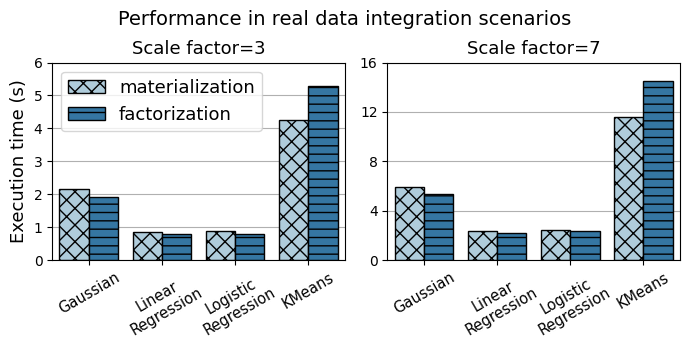

In [113]:

data=[['scale factor','model','execution time','training method'],
      [3,'Gaussian',2.17,'materialization'],
      [3,'Gaussian',1.90,'factorization'],
       [3,'Linear Regression',0.84,'materialization'],
       [3,'Linear Regression',0.79,'factorization'],
       [3,'Logistic Regression',0.87,'materialization'],
       [3,'Logistic Regression',0.80,'factorization'],
    [3,'KMeans',4.25,'materialization'],
    [3,'KMeans',5.30,'factorization'],

    [7,'Gaussian',5.92,'materialization'],
    [7,'Gaussian',5.38,'factorization'],
    [7,'Linear Regression',2.33,'materialization'],
    [7,'Linear Regression',2.21,'factorization'],
    [7,'Logistic Regression',2.46,'materialization'],
    [7,'Logistic Regression',2.33,'factorization'],
    [7,'KMeans',11.56,'materialization'],
    [7,'KMeans',14.53,'factorization']
]
di_data=pd.DataFrame(data[1:],columns=data[0])
di_data=di_data[['scale factor','model','execution time','training method']]
palette=['#a6cee3','#1f78b4','#b2df8a']
sns.set_palette('Paired')

fig, axes = plt.subplots(1, 2, sharey=False, figsize=(7,3.5))
h=[3,7]
j=0
edgecolor='black'
for i in range(2):
    ax = axes[i]
    g1=sns.barplot(ax=ax,x='model', y='execution time', hue='training method', data=di_data[di_data['scale factor']==h[i]], ci=None, edgecolor=edgecolor, alpha=0.99)
    # axes[i][j].set_title('Speedup of Different Operators for Different CR Intervals')
    legends=[]
    for bar, pattern, label in zip(g1.containers, hatch_patterns, ['materialization', 'factorization']):
        plt.setp(bar, hatch=pattern)
        barinfo = bar.patches[0]
        legends.append(mpatches.Patch(facecolor=barinfo.get_facecolor(), label=label, edgecolor=barinfo.get_edgecolor(), hatch=barinfo.get_hatch()))

    ax.set_xticklabels([label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()], rotation=30)
    ax.set_xlabel('')
    ax.set_title(f'Scale factor={h[i]}', fontsize=13)
    ax.set_ylabel('Execution time (s)', fontsize=13)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(10.5)
    
    if i==0:
        ax.set_ylim(0,6)
        ax.legend(handles=legends, fontsize=13)
    else:
        ax.set_ylim(0,16)
        ax.set_yticks([0, 4,8,12,16])
        ax.get_legend().remove()
        ax.yaxis.label.set_text('')
        
fig.tight_layout()
fig.suptitle('Performance in real data integration scenarios', fontsize=14)
fig.subplots_adjust(top=0.83)
fig.savefig("figures/TPC-DI.pdf",bbox_inches='tight')


In [64]:
hatch_patterns

<generator object <genexpr> at 0x7fa6e023e8f0>